In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nuaa-encrypted-dataset/client_train_face.txt
/kaggle/input/nuaa-encrypted-dataset/imposter_train_face.txt
/kaggle/input/nuaa-encrypted-dataset/readme.txt
/kaggle/input/nuaa-encrypted-dataset/imposter_test_face.txt
/kaggle/input/nuaa-encrypted-dataset/client_test_face.txt
/kaggle/input/nuaa-encrypted-dataset/EncryptedFace/EncryptedFace/ImposterFace/0007/0007_01_02_03_226.jpg
/kaggle/input/nuaa-encrypted-dataset/EncryptedFace/EncryptedFace/ImposterFace/0007/0007_01_00_01_292.jpg
/kaggle/input/nuaa-encrypted-dataset/EncryptedFace/EncryptedFace/ImposterFace/0007/0007_01_00_01_469.jpg
/kaggle/input/nuaa-encrypted-dataset/EncryptedFace/EncryptedFace/ImposterFace/0007/0007_01_00_01_61.jpg
/kaggle/input/nuaa-encrypted-dataset/EncryptedFace/EncryptedFace/ImposterFace/0007/0007_01_03_02_461.jpg
/kaggle/input/nuaa-encrypted-dataset/EncryptedFace/EncryptedFace/ImposterFace/0007/0007_01_01_03_48.jpg
/kaggle/input/nuaa-encrypted-dataset/EncryptedFace/EncryptedFace/ImposterFace/0007/000

In [40]:
import torch
import sys
import os
from __future__ import print_function, division
import matplotlib.pyplot as plt
from torchvision import transforms, utils
import torchvision.transforms as transforms
import torchvision.models as models
from skimage.transform import resize
import torch.nn as nn
import torch.nn.functional as F
import cv2
import re
import pandas as pd
import numpy as np

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode


In [41]:
torch.cuda.is_available()

True

In [42]:
# Set device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [43]:
# combining real and fake faces file for training and dev

client_train_txt_file="/kaggle/input/nuaa-encrypted-dataset/client_train_face.txt"
imposter_train_txt_file="/kaggle/input/nuaa-encrypted-dataset/imposter_train_face.txt"

client_train_images_loc="/kaggle/input/nuaa-encrypted-dataset/EncryptedFace/EncryptedFace/ClientFace/"
imposter_train_images_loc="/kaggle/input/nuaa-encrypted-dataset/EncryptedFace/EncryptedFace/ImposterFace/"

train_dev_data=[(client_train_txt_file, client_train_images_loc, 1), (imposter_train_txt_file, imposter_train_images_loc, 0 )] # encoding the class

train_dev_img_list=list() # list containing the location of images

with open("train_combined.txt", "w") as out:
  for a,b,c in train_dev_data:
    with open(a, "r") as file:
      for line in file:
        line=line.rstrip()
        folder=re.findall("([0-9]+)\\\\", line)[0]
        image=re.findall("[0-9_]+.jpg", line)[0]
        train_dev_img_list.append(b+folder+"/"+image+"/"+str(c))
        out.write(b+folder+"/"+image+"/"+str(c)+"\n") #-----> format: folder/image_name


read_file_train=pd.read_csv (r'/kaggle/working/train_combined.txt', header = None)
read_file_train.columns = ["image"]
read_file_train.to_csv (r"train_combined.csv", index=None)

print(f"Total number of examples for training: {len(read_file_train)}")

Total number of examples for training: 3491


In [44]:
# combining real and fake faces file for testing and converting it to a csv

client_test_txt_file="/kaggle/input/nuaa-encrypted-dataset/client_test_face.txt"
imposter_test_txt_file="/kaggle/input/nuaa-encrypted-dataset/imposter_test_face.txt"

client_test_images_loc="/kaggle/input/nuaa-encrypted-dataset/EncryptedFace/EncryptedFace/ClientFace/"
imposter_test_images_loc="/kaggle/input/nuaa-encrypted-dataset/EncryptedFace/EncryptedFace/ImposterFace/"

test_data=[(client_test_txt_file,client_test_images_loc, 1),(imposter_test_txt_file, imposter_test_images_loc, 0)]

test_img_list=list() # list containing the location of images

with open("test_combined.txt", "w") as out:
  for a,b,c in test_data:
    with open(a, "r") as file:
      for line in file:
        line=line.rstrip()
        folder=re.findall("([0-9]+)\\\\", line)[0]
        image=re.findall("[0-9_]+.jpg", line)[0]
        test_img_list.append(b+folder+"/"+image+"/"+str(c))
        out.write(b+folder+"/"+image+"/"+str(c)+"\n") #-----> format: folder/image_name

read_file_test = pd.read_csv (r'/kaggle/working/test_combined.txt', header = None)
read_file_test.columns = ["image"]
read_file_test.to_csv (r"test_combined.csv", index=None)

print(f"Total number of examples for testing: {len(read_file_test)}")


Total number of examples for testing: 9123


In [45]:
# custom class to explore dataset

from torch.utils.data import Dataset, DataLoader
from PIL import Image

class face_dataset(Dataset):
  def __init__(self, data_split_csv_loc, transform=None):
    self.data_split_csv_loc=pd.read_csv(data_split_csv_loc)
    self.transform=transform


  def __len__(self):  # returns the length of the data set
     return len(self.data_split_csv_loc)

  def __getitem__(self, idx):
    img_loc=self.data_split_csv_loc.iloc[idx,0][:-2]
    img_class=int(self.data_split_csv_loc.iloc[idx,0][-1])
    img_transform=self.transform(Image.open(img_loc))

    return  img_transform,   img_class  #---> returned values are a touple and image class

In [46]:
# LBP+sharpen for transforms

from skimage.feature import local_binary_pattern

class to_LBP():
  '''class to calculate LBP'''

  def __init__(self, n_points_radius, method):
    self.n_points=n_points_radius
    self.method=method
    self.channels=len(self.n_points)
    self.kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])


  def  __call__(self, sample):
    w, h=sample.size
    temp=np.zeros((self.channels, w, h))
    image=np.array(sample)
    image=cv2.filter2D(image, -1, self.kernel)
    for idx, values in enumerate(self.n_points):
      lbp=local_binary_pattern(image, values[0], values[1], self.method)
      temp[idx]=lbp
    return (temp,  image)

In [47]:
# Here we create two seperate instances of the face_dataset class. One will hold the data set for training and the other will hold data for dev

lbp_maps=lbp_maps=[(3,3),(4,1), (4,2), (8,1), (8,2), (8,3), (8,5), (16,2), (16,3), (16,5)]
num_input_channels=len(lbp_maps)
print(f"Number of input channels: {num_input_channels}")

train_dataset=face_dataset(data_split_csv_loc="/kaggle/working/train_combined.csv", transform=transforms.Compose([transforms.Resize((64,64)),  transforms.RandomHorizontalFlip(),  to_LBP(n_points_radius=lbp_maps, method="uniform")]))
test_dataset=face_dataset(data_split_csv_loc="/kaggle/working/test_combined.csv", transform= transforms.Compose([transforms.Resize((64,64)),   to_LBP(n_points_radius=lbp_maps, method="uniform")]))


len_train_dataset, len_test_dataset, =len(train_dataset), len(test_dataset)
print(f"Total number of elements in training dataset: {len_train_dataset}")
print(f"Total number of elements in test dataset: {len_test_dataset}")

Number of input channels: 10
Total number of elements in training dataset: 3491
Total number of elements in test dataset: 9123


In [48]:
# function for plotting LBP

def plot( touple):
  fig, axs = plt.subplots(touple[0].shape[0], touple[0].shape[1]+1, figsize=(25,25))

  """plotting the images on which lbp is calculated """
  for img in range(touple[1].shape[0]):
    axs[img, 0 ].imshow(touple[1][img])

  """plotting the LBP of the image """
  for example in range(touple[0].shape[0]):
    for image in range(touple[0].shape[1]):
      axs[example, image+1].imshow(touple[0][example][image])

In [49]:
#custom transformation to convert images to grayscale
class face_dataset(Dataset):
    def __init__(self, data_split_csv_loc, transform=None):
        self.data_split_csv_loc = pd.read_csv(data_split_csv_loc)
        self.transform = transform

    def __len__(self):
        return len(self.data_split_csv_loc)

    def __getitem__(self, idx):
        img_loc = self.data_split_csv_loc.iloc[idx, 0][:-2]
        img_class = int(self.data_split_csv_loc.iloc[idx, 0][-1])

        # Load the image
        img = Image.open(img_loc)

        # Convert the image to grayscale
        img = img.convert('L')

        if self.transform is not None:
            img = self.transform(img)

        return img, img_class


In [50]:
train_dataset = face_dataset(data_split_csv_loc="/kaggle/working/train_combined.csv", transform=transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    to_LBP(n_points_radius=lbp_maps, method="uniform")
]))

test_dataset = face_dataset(data_split_csv_loc="/kaggle/working/test_combined.csv", transform=transforms.Compose([
    transforms.Resize((64, 64)),
    to_LBP(n_points_radius=lbp_maps, method="uniform")
]))


In [51]:
plot_loader=DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=8)

for batch, label  in plot_loader:  # getting one batch for visualizing data
  print(batch[0].shape)

  break



torch.Size([16, 10, 64, 64])


label: tensor([0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1])


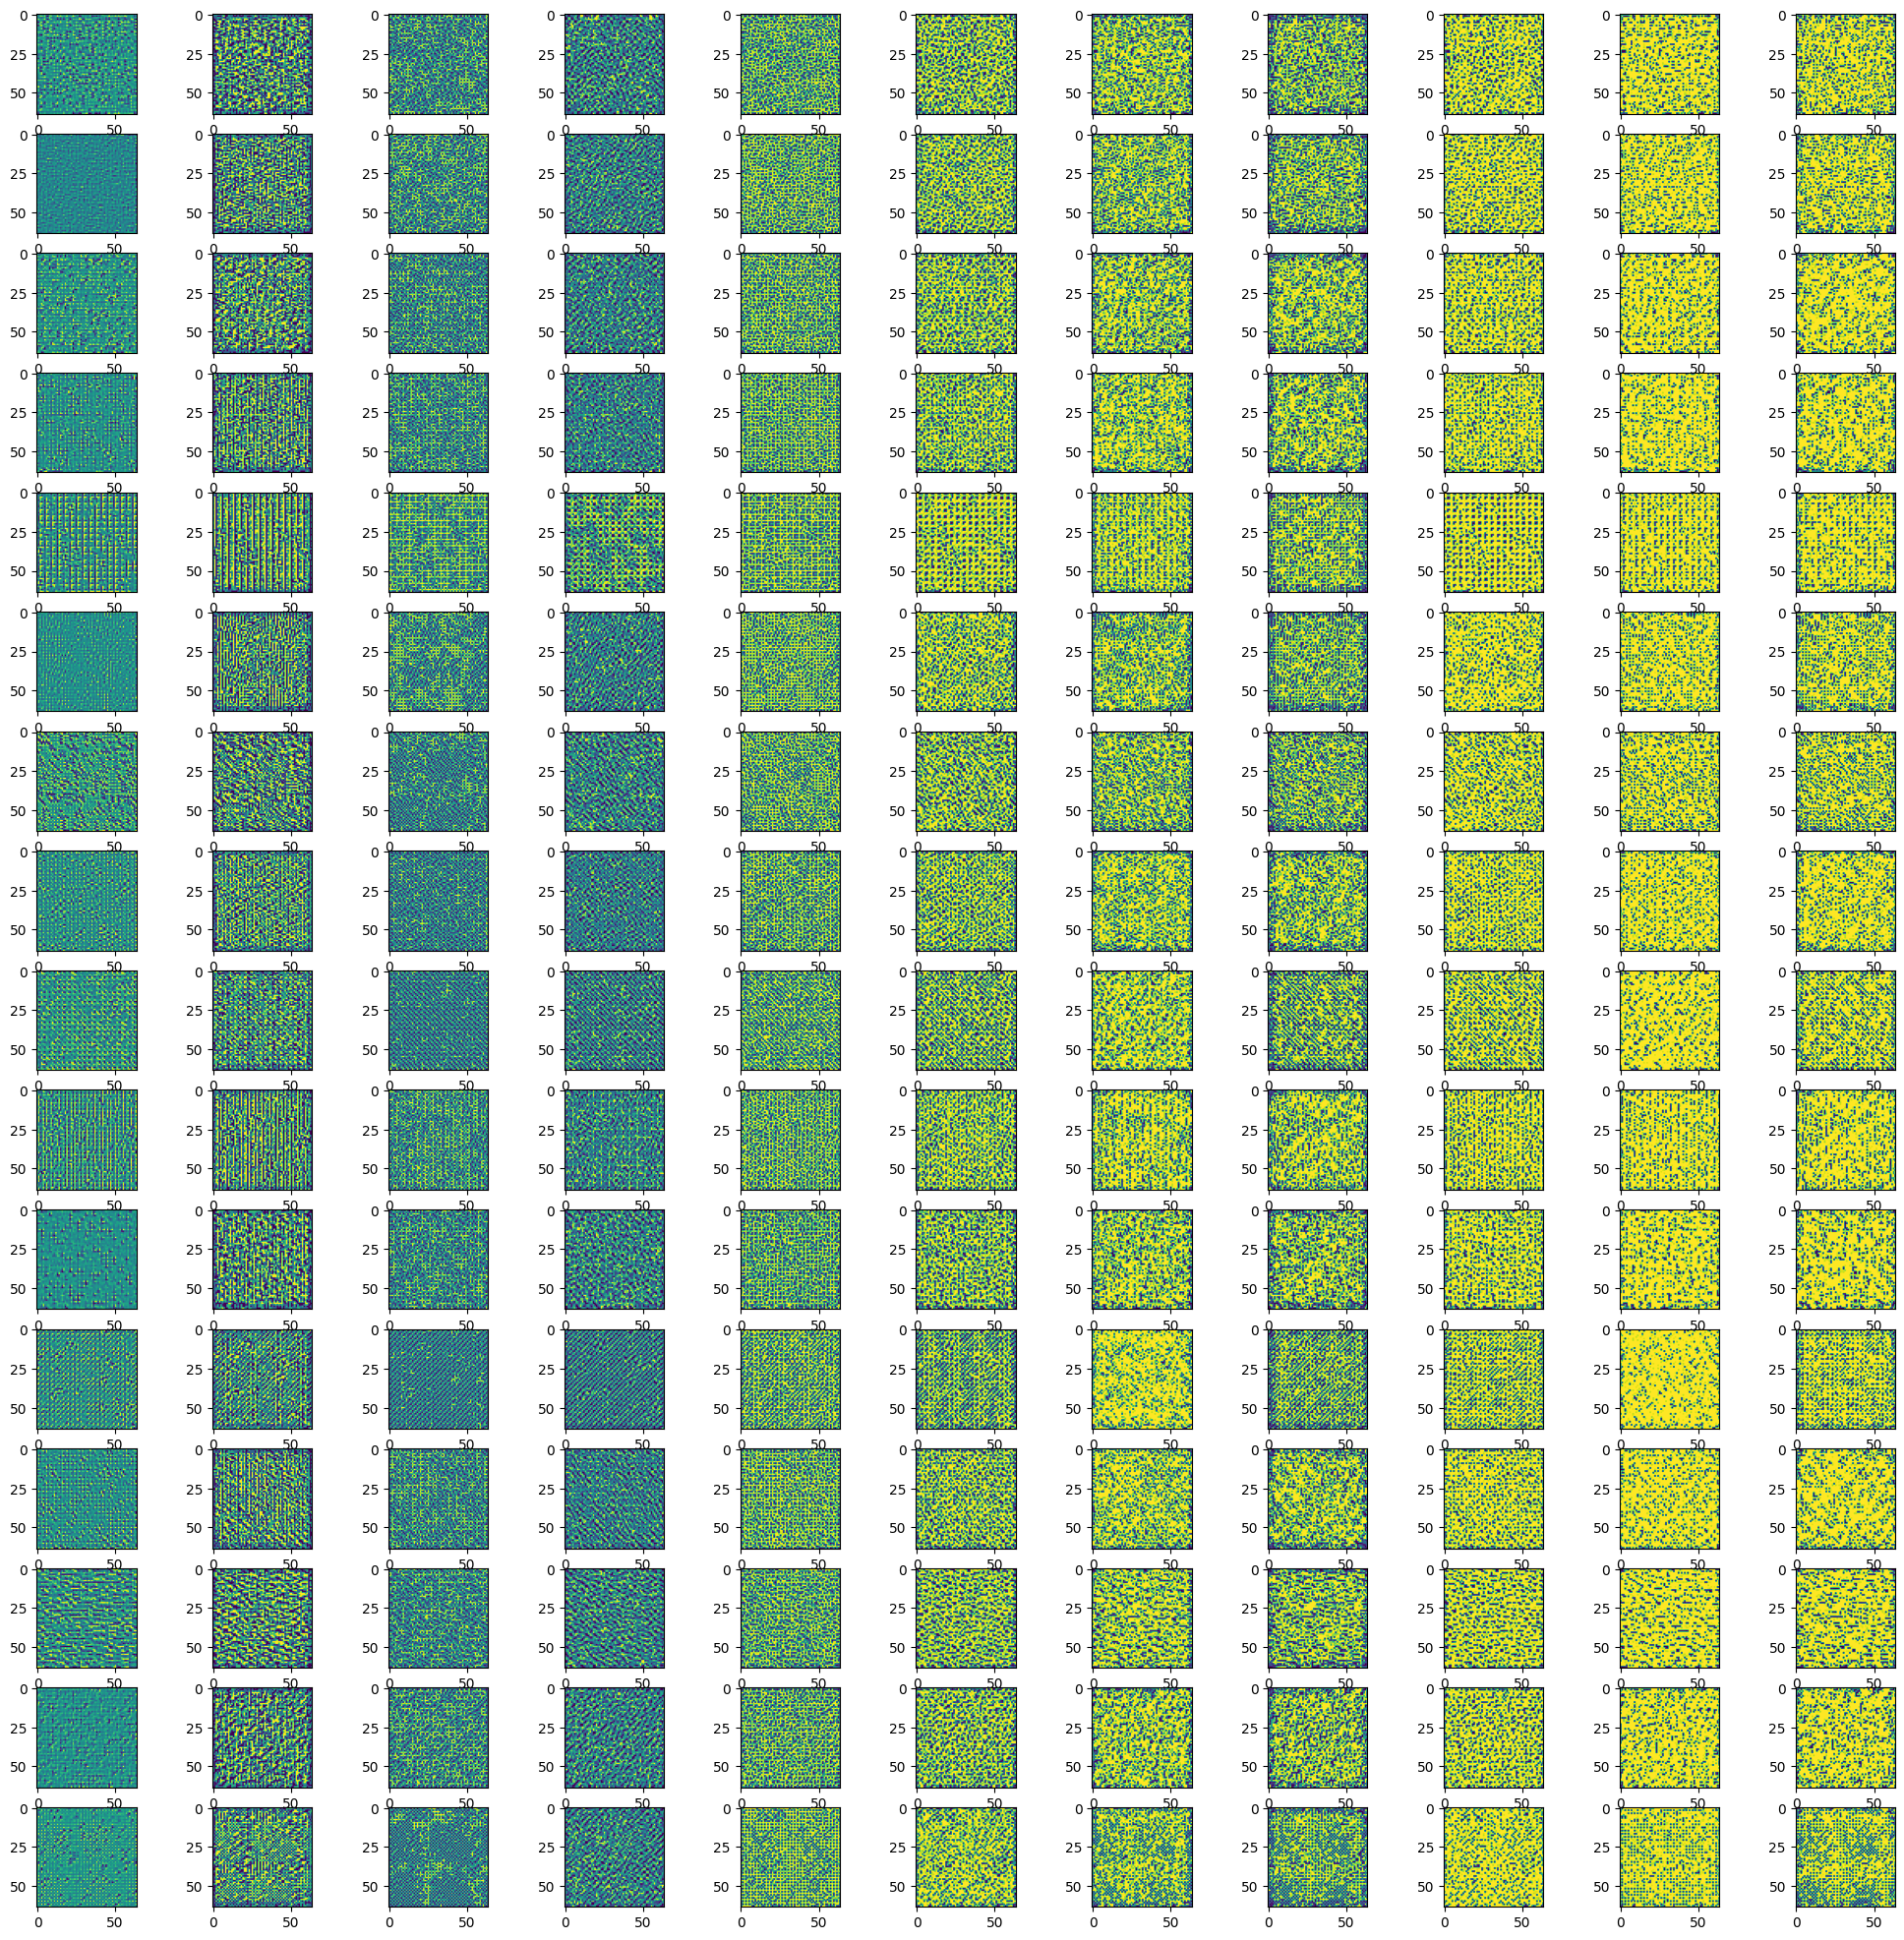

In [52]:
print(f"label: {label}")
plot(batch)

In [53]:
# get true positives, true negatives,  false positives and false negatives

def confusion_matrix(ys, y_preds):
  ys=ys.detach()
  ys=ys.to("cpu")
  y_preds=y_preds.detach()
  y_preds=y_preds.to("cpu")

  ys=np.asarray(ys)
  y_preds=np.asarray(y_preds)

  tp=np.sum((y_preds == 1) & (ys == 1))
  tn=np.sum((y_preds == 0) & (ys == 0))
  fp=np.sum((y_preds == 1) & (ys == 0))
  fn=np.sum((y_preds == 0) & (ys == 1))

  print(f"tp:{tp}, tn: {tn}, fp:{fp}, fn: {fn}")

  return tp, tn, fp, fn

In [54]:
# def confusion matrix test

a=torch.Tensor([1,1,1,0,0,0])
b=torch.Tensor([0,1,0,1,0,1])

TP, TN, FP, FN=confusion_matrix(a, b)
print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")
print("Answer:TP: 1, TN: 1, FP: 2, FN: 2")

tp:1, tn: 1, fp:2, fn: 2
TP: 1, TN: 1, FP: 2, FN: 2
Answer:TP: 1, TN: 1, FP: 2, FN: 2


In [55]:
# HTER claculation for test and validation
def HTER(model, loss_criterion, loader):
  Ys=list()
  Y_preds=list()
  Loss_total=0
  total_step=len(loader)

  for touple, label in loader:
    batch=touple[0]
    batch=batch.to(device=device, dtype=torch.float)
    label=label.to(device=device, dtype=torch.long)
    Ys.append(label)
    Y_pred=model(batch)
    Y_preds.append(torch.argmax(Y_pred, dim=1))
    Loss=loss_criterion(Y_pred,label)
    Loss_total += Loss.item()


  Y= torch.cat(Ys, dim=0)
  Y_pred=torch.cat(Y_preds, dim=0)
  tp, tn, fp, fn =confusion_matrix(Y, Y_pred)
  hter=1-(0.5*((tp/(tp+fn))+(tn/(tn+fp))))

  return (hter*100, Loss_total/total_step)

In [56]:
# solver function for Neural Network

def Solver_NN(model, train_loader, test_loader, optim, criterion, device, print_every=10, epoch=51, lr=1e-1):
  print("Solver Initiated")
  model=model.to(device) # sending model to GPU
  print("Model successfully sent to the GPU\n")

  print_every=print_every
  total_step = len(train_loader)
  counter=0

  for e in range(epoch):
    model.train()
    running_loss = 0.0
    epoch_loss=0.0
    for i, (x,y) in enumerate(train_loader):
      optim.zero_grad()

      X=x[0]
      X=X.to(device=device, dtype=torch.float)
      y=y.to(device=device, dtype=torch.long)

      #forward pass########
      y_pred=model(X)
      loss=criterion(y_pred, y)
      ####################

      # backward pass#######
      loss.backward()
      optim.step()
      ####################
      running_loss += loss.item()
      epoch_loss+=running_loss
      if (i+1) % print_every == 0:       # print every 10
        print ("Epoch [{}/{}], Step [{}/{}] Loss: {}".format(counter+1, epoch, i+1, total_step, running_loss/print_every))
        running_loss = 0.0
    counter+=1
    model.eval()
    with torch.no_grad():
      train_hter, train_loss=HTER(model=model, loss_criterion=criterion, loader=train_loader)
      test_hter, test_loss=HTER(model=model, loss_criterion=criterion, loader=test_loader)
      print(f"Train loss in epoch {e+1} is {(train_loss)} and Train HTER in epoch {e+1}: {train_hter}")
      print(f"Test loss in epoch {e+1} is {(test_loss)} and Test HTER in epoch {e+1}: {test_hter}")
    torch.save(model.state_dict(), '/kaggle/working/HTER '+str(test_hter)+'.pkl')
    print("Model saved successfully!\n")

  return model

In [57]:
class Resnet(nn.Module):
  def __init__(self, inp_channels, model):
    super().__init__()
    self.inp_channels=inp_channels
    self.first=nn.Sequential(nn.Conv2d(self.inp_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), nn.ReLU(inplace=True))
    self.cnn=nn.Sequential(*(list(model.children())[1:5]), nn.AdaptiveAvgPool2d(output_size=(1, 1)), nn.Flatten())
    self.fc=nn.Sequential( nn.Linear(256, 128), nn.Dropout(p=0.5), nn.Linear(128, 64), nn.Dropout(p=0.5), nn.Linear(64, 2))

  def forward(self, x):

    x=self.first(x)
    #print(f"1: {x.shape}")

    x=self.cnn(x)
    #print(f"2: {x.shape}")

    x=self.fc(x)
    #print(f"3 {x.shape}")

    return x

In [58]:
resnet=torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=False)
model= Resnet(num_input_channels, resnet )
print(model)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Resnet(
  (first): Sequential(
    (0): Conv2d(10, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): ReLU(inplace=True)
  )
  (cnn): Sequential(
    (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (

In [59]:
#criterion and optimizer
from torch.optim.lr_scheduler import ReduceLROnPlateau

lr=0.01
criterion=nn.CrossEntropyLoss(reduction='mean') # loss criterion
optim=torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01) # optimizer

In [60]:
# GPU Access and model parameters
use_cuda = True
if use_cuda and torch.cuda.is_available():
  print("Running on Cuda")
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("Learnable parameters:",params)

Running on Cuda
Learnable parameters: 288578


In [72]:
# loading training and validation data for the neural network

train_loader=DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8)
test_loader=DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=8)

In [ ]:
model=Solver_NN(model, train_loader, test_loader, optim,criterion, device,print_every=11, epoch=100, lr=lr)

Solver Initiated
Model successfully sent to the GPU

Epoch [1/100], Step [11/28] Loss: 0.45375353639776056
Epoch [1/100], Step [22/28] Loss: 0.4482207542115992
tp:1339, tn: 1413, fp:335, fn: 404
tp:2394, tn: 4183, fp:1578, fn: 968
Train loss in epoch 1 is 0.449551023542881 and Train HTER in epoch 1: 21.171593861552786
Test loss in epoch 1 is 0.5704743079841137 and Test HTER in epoch 1: 28.091731711344238
Model saved successfully!

Epoch [2/100], Step [11/28] Loss: 0.44852029193531384
Epoch [2/100], Step [22/28] Loss: 0.4618885490027341
tp:1370, tn: 1404, fp:344, fn: 373
tp:2451, tn: 4127, fp:1634, fn: 911
Train loss in epoch 2 is 0.44506888943059103 and Train HTER in epoch 2: 20.539759561291916
Test loss in epoch 2 is 0.573228381988075 and Test HTER in epoch 2: 27.730048746205306
Model saved successfully!

Epoch [3/100], Step [11/28] Loss: 0.48443361304023047
Epoch [3/100], Step [22/28] Loss: 0.4305345199324868
tp:1356, tn: 1433, fp:315, fn: 387
tp:2465, tn: 4110, fp:1651, fn: 897
Trai

In [68]:

test_loader=DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=8)
len_test_dataset= len(test_dataset)

print(f"Total number of elements in test dataset: {len_test_dataset}")

Total number of elements in test dataset: 9123


In [69]:
criterion=nn.CrossEntropyLoss(reduction='mean') # loss criterion
resnet=torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=False)
model= Resnet(num_input_channels, resnet )


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [70]:
model.load_state_dict(torch.load("/kaggle/working/HTER 28.86276270902387.pkl"))

<All keys matched successfully>

In [71]:
model=model.to(device)
model.eval()
with torch.no_grad():
      test_hter, test_loss=HTER(model=model, loss_criterion=criterion, loader=test_loader)
      print(f"Test loss  is {(test_loss/len_test_dataset)}")
      print(f'Test HTER: {test_hter}\n')



tp:2170, tn: 4478, fp:1283, fn: 1192
Test loss  is 6.293183662451847e-05
Test HTER: 28.86276270902387

